## What's the point of this notebook?
This notebook shows how an audio-to-image model works. It walks through loading audio, encoding it, and generating images using a SDXL 1.0. The goal is to make the inference pipeline understandable.

In [1]:
import sys
sys.path.append("../A2I_model")
from sdxl_helpers import StableDiffusionHelper
from helpers_general import load_song_whole_in_clips, load_song_clip, seed_everything, save_as_video_clip, assert_ffmpeg_available
from models import AudioEncoder
import torch
from justshowit import show_grid_configurable
from tqdm.notebook import tqdm
seed_everything(42)

# Load songs clips

In [2]:
song_path = "../dataset/tutorial_data/example_song.mp3"
sequence_of_song_clips = load_song_whole_in_clips(song_path) # 42 second song clip
print([c.shape for c in sequence_of_song_clips])
a_single_song_clip = load_song_clip(song_path, crop_method="center")
print(a_single_song_clip.shape)

[(480000,), (480000,), (480000,), (480000,)]
(480000,)


# Load pretrained audio-encoder

In [3]:
audio_encoder = AudioEncoder(device="cuda:0")
checkpoint = torch.load("../weights/pretrained.pth") 
print(checkpoint.keys())
audio_encoder.load_state_dict(checkpoint["model_state_dict"])
audio_encoder.eval();

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])


# Setup audio-guided SDXL

In [4]:
# Load model
helper = StableDiffusionHelper()
helper.load_pipeline()

# Generate a couple of images with and without the audio encoder
NOTE: See result at `../dataset/tutorial_data/single_image.jpg`

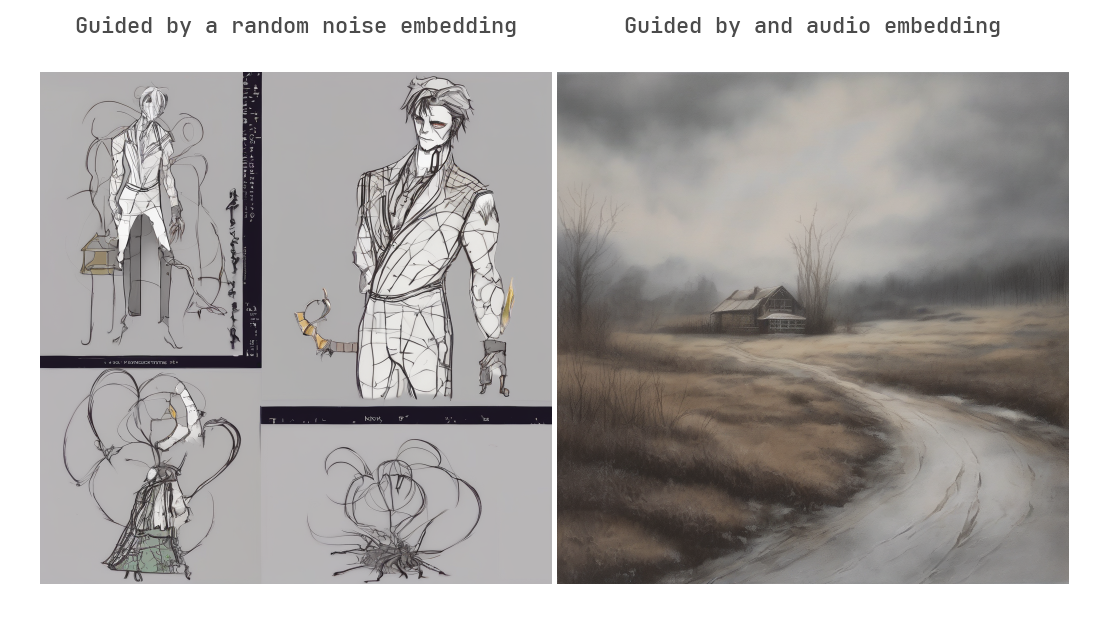

In [5]:
# Generate an image with a random prompt embedding
prompt_embedding = torch.randn([1, 77, 2048], device="cuda:0") # 
image_random = helper.generate_image(prompt_embedding, guidance_scale=5.0)

# Generate an image using the audio encoder
with torch.no_grad():
    audio_embedding = audio_encoder(a_single_song_clip)
image_audio = helper.generate_image(audio_embedding, guidance_scale=40.0)

# Show images
show_grid_configurable(
    [image_random, image_audio], 
    col_text=[f"Guided by a random noise embedding", f"Guided by and audio embedding"],
    cols=2, resize_factor=0.5,
    save_image_path="../dataset/tutorial_data/single_image.jpg"
)

# Save song and generated image as a video clip
<span style="color:red"><strong>NOTE:</strong> <code>ffmpeg</code> must be in the environment paths.</span><br>
NOTE: See result at `../dataset/tutorial_data/example_song_with_generated_image.mp4`



In [6]:
assert_ffmpeg_available()
save_as_video_clip(
    audio_samples=a_single_song_clip, 
    image=image_audio, 
    video_output_path="../dataset/tutorial_data/example_song_with_generated_image.mp4"
)

# Generate images from a sequence of song clips
NOTE: See result at `../dataset/tutorial_data/sequence_image.jpg` <br>
NOTE: This while take a couple of minutes, if you're impatient set `repeat_x_number_of_times=1`

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

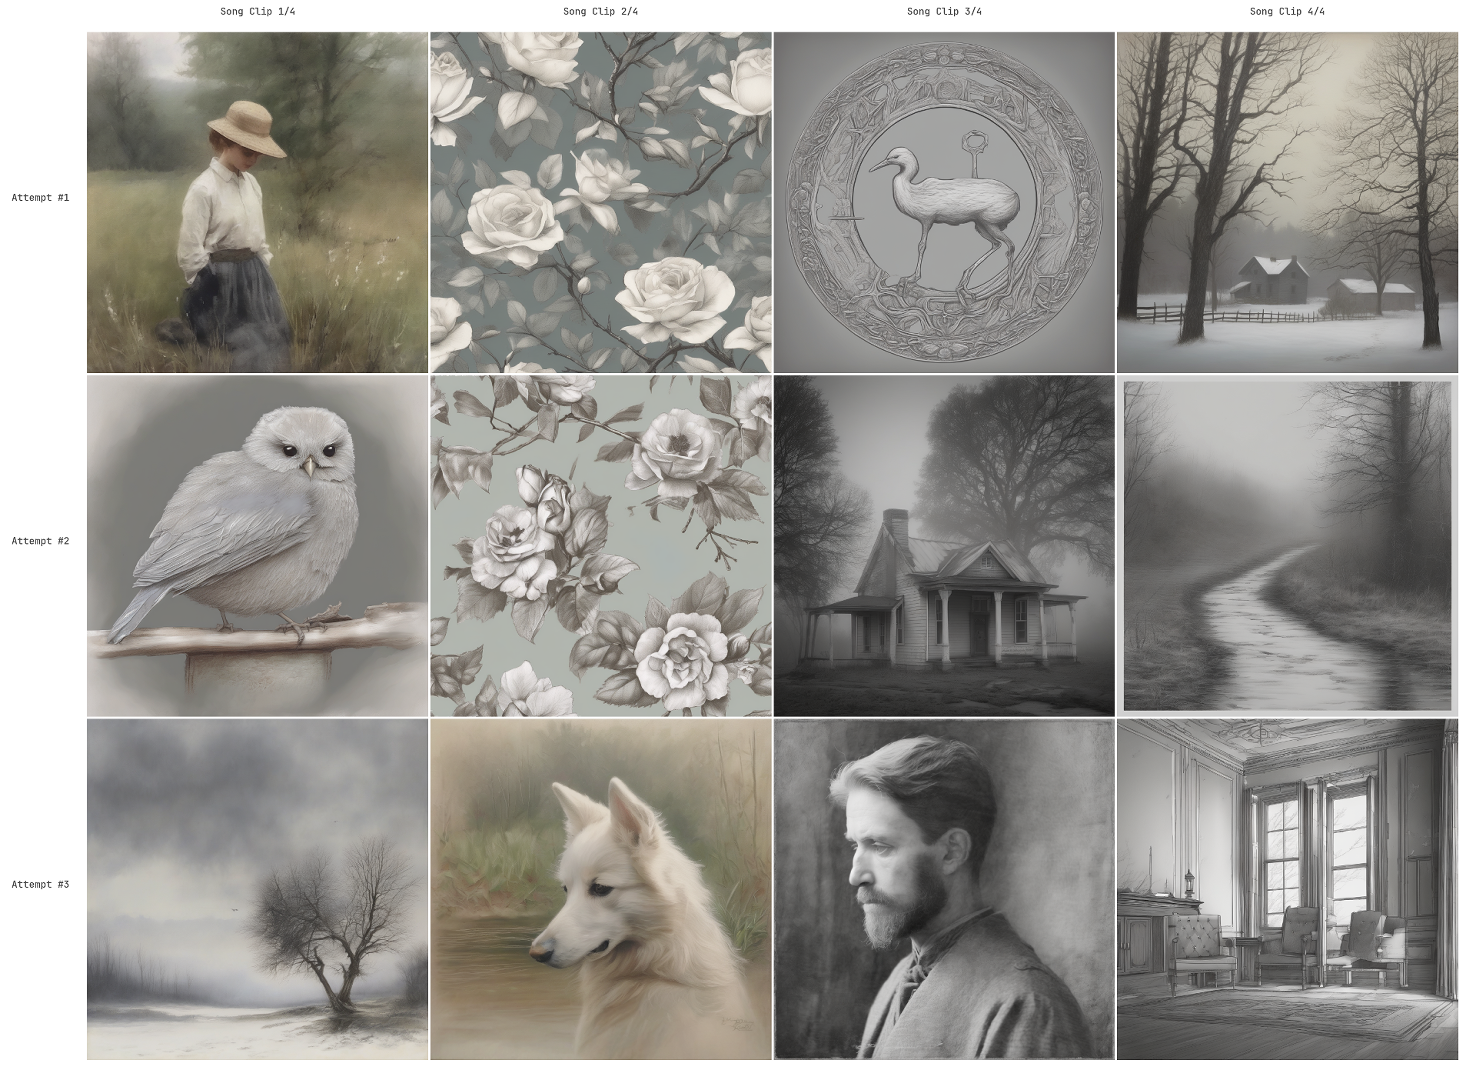

In [7]:
# Generate sequences of images using the audio encoder
images = []
repeat_x_number_of_times = 3
for i in tqdm(range(repeat_x_number_of_times)):
    for clip in tqdm(sequence_of_song_clips, leave=False):
        with torch.no_grad():
            audio_embedding = audio_encoder(clip)
        image_audio = helper.generate_image(audio_embedding, guidance_scale=30.0)
        images.append(image_audio)

# Show images
C = len(sequence_of_song_clips)
R = len(sequence_of_song_clips)
show_grid_configurable(
    images,
    row_text=[f"Attempt #{i}" for i in range(1, R+1)],
    rows=R, 
    col_text=[f"Song Clip {i}/{C}" for i in range(1, C+1)],
    cols=C, 
    resize_factor=0.75,
    save_image_path="../dataset/tutorial_data/sequence_image.jpg"
)

# Remember to free the memory

In [8]:
helper.clear_pipeline()